<a href="https://colab.research.google.com/github/Lavkesh-kumar/Solar-panel-Detection/blob/main/Data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

In [2]:
# Prepare folder structure
PROJECT_FOLDER = "/content/drive/MyDrive/Solar panel detection/"
DATA_FOLDER = "/home/data/"
TRAIN_DATA_FOLDER = PROJECT_FOLDER + 'unziped_train/'
TEST_DATA_FOLDER = PROJECT_FOLDER + 'unziped_evaluation/'
SAMPLE_DATA_FOLDER = PROJECT_FOLDER + 'unziped_sample/'

In [3]:
import os
import random
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:

def load_image_masks(folder_name, file_names):
    image_data = []
    mask_data = []

  # train image path = /gdrive/MyDrive/Solar panel detection/unziped_train/s2_image/train_s2_image_0.tif
  # mask path = /gdrive/MyDrive/Solar panel detection/unziped_train/mask/train_mask_0.tif

    for fn in tqdm(file_names):
        postfix = fn.split("_")[3]
        image_path = f"{folder_name}/s2_image/{fn}"
        mask_path = f"{folder_name}/mask/train_mask_{postfix}"

        # Check if files exist and are not empty
        if os.path.exists(image_path) and os.path.getsize(image_path) > 0:
            image_data.append(tifffile.imread(image_path))
        else:
            print(f"Warning: Image file not found or empty: {image_path}")

        if os.path.exists(mask_path) and os.path.getsize(mask_path) > 0:
            mask_data.append(tifffile.imread(mask_path))
        else:
            print(f"Warning: Mask file not found or empty: {mask_path}")

    return image_data, mask_data

In [7]:
train_image_files = os.listdir(f'{TRAIN_DATA_FOLDER}s2_image/')     #[:500]
train_image_data, train_mask_data = load_image_masks(TRAIN_DATA_FOLDER, train_image_files)

 56%|█████▋    | 1163/2066 [00:25<00:06, 135.94it/s]

100%|██████████| 2066/2066 [11:14<00:00,  3.06it/s]


Images are not the same length so I use [padding] to increase the size and the center crop to have all images of size 32x32. This way all images are the same size but the spatial resolution is not changed like it would be when using resize.

In [8]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="reflect"),
    v2.RandomRotation(degrees=90),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.CenterCrop((32,32)),
    v2.ToDtype(torch.float32, scale=False),
])


val_transforms = v2.Compose([
    v2.ToImage(),
    v2.Pad((6,6), padding_mode="reflect"),
    v2.CenterCrop((32,32)),
    v2.ToDtype(torch.float32, scale=False),
])

In [9]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        images,
        masks,
        transforms,
    ):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, index):
        image = self.images[index]# / 10_000 # scale by scaling factor
        mask = self.masks[index]
        mask = np.expand_dims(mask, 2) # [x,y] => [x,y,1]
        image, mask = self.transforms(image, mask)

        return {"image": image, "mask": mask}

ds = ImageTrainDataset(train_image_data, train_mask_data, transforms=train_transforms)

Image, Mask and Image+mask corresponding to training example : 1334


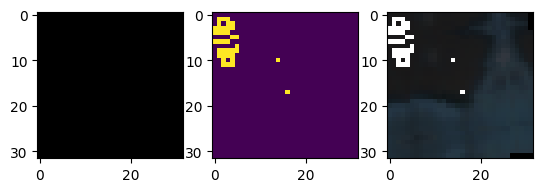

Image, Mask and Image+mask corresponding to training example : 1883


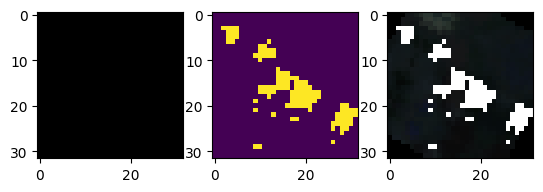

Image, Mask and Image+mask corresponding to training example : 980


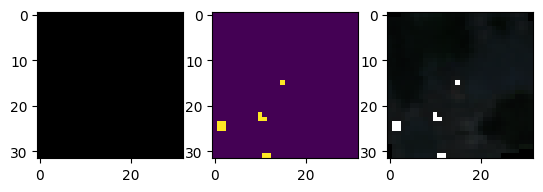

In [10]:
def display_data(ds):
  for i in range(3):
    choice = random.randint(0, len(ds))
    fig, axes = plt.subplots(1,3)
    print("Image, Mask and Image+mask corresponding to training example :",choice)
    d = ds[choice]
    axes[0].imshow(d["image"][1:4].permute(1,2,0) / (255*10000))
    axes[1].imshow(d["mask"][0]/255)
    axes[2].imshow((d["mask"][0] + d["image"][1:4] / 10000).permute(1,2,0))
    plt.show()

display_data(ds)